In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, callbacks
from tensorflow.keras.layers import InputLayer, Input, Dense, Flatten, Conv2D, MaxPooling2D, Reshape, LSTM, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tqdm import tqdm

tf.config.run_functions_eagerly(True)

In [24]:
import os

def generate_image_csv(root_dir, output_csv):
    # Inizializza le liste per i percorsi delle immagini e le classi
    image_paths = []
    image_classes = []

    # Itera su ogni directory nel directory radice
    for dir_name in os.listdir(root_dir):
        # Il nome della directory è la classe dell'immagine
        image_class = dir_name

        # Il percorso della directory
        dir_path = os.path.join(root_dir, dir_name)

        # Se il percorso non è una directory, salta al prossimo
        if not os.path.isdir(dir_path):
            continue

        # Itera su ogni file nella directory
        for file_name in os.listdir(dir_path):
            # Il percorso del file
            file_path = os.path.join(dir_path, file_name)

            # Se il file non è un'immagine, salta al prossimo
            if not file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            # Aggiungi il percorso del file e la classe dell'immagine alle liste
            image_paths.append(file_path)
            image_classes.append(image_class)

    # Crea un DataFrame con i percorsi delle immagini e le classi
    df = pd.DataFrame({
        'image': image_paths,
        'label': image_classes
    })

    # Scrivi il DataFrame in un file CSV
    df.to_csv(output_csv, index=False)



In [25]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
CLASSES = ["Dementia", "NoDementia"]
NUM_CLASSES = len(CLASSES)

TRAIN_PATH = "./Datasets/Train"
# Usa la funzione per generare il CSV
generate_image_csv(TRAIN_PATH, './csv/train.csv')

TEST_PATH = "./Datasets/Test"
# Usa la funzione per generare il CSV
generate_image_csv(TEST_PATH, './csv/test.csv')

In [26]:
# Define the CNN model
def create_cnn():
    model = models.Sequential()

    # 0. Input layer
    model.add(InputLayer(input_shape=(1, 128, 128, 3)))
    
    # 1. Convolutional layer with L2 regularization and batch normalization
    layer = Conv2D(64, (3, 3), activation='relu')
    model.add(TimeDistributed(layer))
    
    # 2. MaxPooling layer
    layer = MaxPooling2D((2, 2))
    model.add(TimeDistributed(layer))
    
    # 3. Convolutional layer with L2 regularization and batch normalization
    layer = Conv2D(32, (3, 3), activation='relu')
    model.add(TimeDistributed(layer))
    
    # 4. MaxPooling layer
    layer = MaxPooling2D((2, 2))
    model.add(TimeDistributed(layer))
    
    # 5. Flattening layer
    layer = Flatten()
    model.add(TimeDistributed(layer))

    # 6. LSTM layer with dropout
    model.add(LSTM(100))
    
    # 7. Dense layer
    model.add(Dense(2, activation='sigmoid'))

    return model

In [27]:
# Create the CNN model
model = create_cnn()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

c:\Users\nikba\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_10             │ (None, 1, 126, 126,    │         1,792 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 1, 63, 63, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 1, 61, 61, 32)  │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 1, 30, 30, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 1, 28800)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │    11,560,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,580,858 (44.18 MB)

 Trainable params: 11,580,858 (44.18 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
train_df = pd.read_csv('./csv/train.csv')
test_df = pd.read_csv('./csv/test.csv')

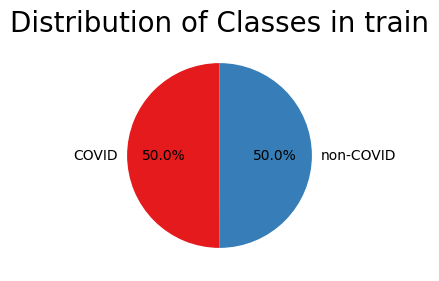

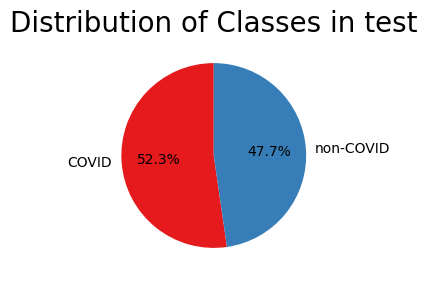

In [29]:
plt.figure(figsize=(3, 3))
class_counts = train_df['label'].value_counts()
tr_labels = class_counts.index
tr_sizes = class_counts.values
plt.pie(tr_sizes, labels=tr_labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set1'))
plt.title('Distribution of Classes in train', fontsize=20)
plt.show()

plt.figure(figsize=(3, 3))
class_counts = test_df['label'].value_counts()
ts_labels = class_counts.index
ts_sizes = class_counts.values
plt.pie(ts_sizes, labels=ts_labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set1'))
plt.title('Distribution of Classes in test', fontsize=20)
plt.show()

In [30]:
for label, size in zip(tr_labels, tr_sizes):
    print(f"Label: {label}, Size: {size}")

Label: COVID, Size: 1000
Label: non-COVID, Size: 999


In [31]:
for label, size in zip(ts_labels, ts_sizes):
    print(f"Label: {label}, Size: {size}")

Label: COVID, Size: 252
Label: non-COVID, Size: 230


In [32]:
work_dr = ImageDataGenerator(rescale=1./255)

In [34]:

# enhancing model generalization
train_samples_num = len(train_df)
train_data_gen = work_dr.flow_from_dataframe(train_df,x_col='image',y_col='label', target_size=IMAGE_SIZE, batch_size=train_samples_num, shuffle=True, class_mode="categorical")
X_train, y_train = train_data_gen.__next__()

Found 1999 validated image filenames belonging to 2 classes.


In [36]:
work_dr = ImageDataGenerator(
    rescale=1./255
)
# enhancing model generalization
test_samples_num = len(test_df)
test_data_gen = work_dr.flow_from_dataframe(test_df,x_col='image',y_col='label', target_size=IMAGE_SIZE, batch_size=test_samples_num, shuffle=True, class_mode="categorical")
X_test, y_test = test_data_gen.__next__()

Found 482 validated image filenames belonging to 2 classes.


In [13]:
# train_data = None
# train_labels = None
# steps = len(train_data_gen)
# for i, (data, labels) in enumerate(train_data_gen):
#     print(i)
#     if i == 0:
#         train_data = data
#         train_labels = labels
#     elif i < steps:
#         train_data = np.concatenate((train_data, data), axis=0)
#         train_labels = np.concatenate((train_labels, labels), axis=0)
#     else:
#         break

# print(train_data.shape, train_labels.shape)

In [37]:
# X_train, X_test, y_train, y_test = train_test_split(train_data,train_labels, test_size=0.2, random_state=42,shuffle=True,stratify=train_labels)
if X_train.ndim == 4:
    X_train = np.expand_dims(X_train, axis=1)
if X_test.ndim == 4:
    X_test = np.expand_dims(X_test, axis=1)
    
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)


X_train shape is  (1999, 1, 128, 128, 3)
X_test shape is  (482, 1, 128, 128, 3)
y_train shape is  (1999, 2)
y_test shape is  (482, 2)


In [39]:
# Define callbacks
callbacks_list = [
   callbacks.EarlyStopping(monitor='accuracy', patience=2),  # Stop training if accuracy doesn't improve after 3 epochs
    callbacks.ModelCheckpoint(filepath='./Models/CNN-LSTM-MIGLIORE-binary_crossentropy-val.keras', monitor='loss'),  # Save the best model based on val_accuracy
]

# Fit the model
history = model.fit(X_train, y_train, batch_size=16, epochs=25, callbacks=callbacks_list, validation_split=0.2)

c:\Users\nikba\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 700ms/step - accuracy: 0.5724 - loss: 0.6693 - precision_2: 0.5630 - recall_2: 0.5913 - val_accuracy: 0.7475 - val_loss: 0.5260 - val_precision_2: 0.7056 - val_recall_2: 0.8150
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 709ms/step - accuracy: 0.8317 - loss: 0.4063 - precision_2: 0.8264 - recall_2: 0.8325 - val_accuracy: 0.8250 - val_loss: 0.4132 - val_precision_2: 0.8274 - val_recall_2: 0.8150
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 729ms/step - accuracy: 0.8614 - loss: 0.3131 - precision_2: 0.8635 - recall_2: 0.8644 - val_accuracy: 0.8025 - val_loss: 0.4351 - val_precision_2: 0.7956 - val_recall_2: 0.8075
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 730ms/step - accuracy: 0.8839 - loss: 0.3030 - precision_2: 0.8874 - recall_2: 0.8843 - val_accuracy: 0.7825 - val_loss: 0.4419 - val_precision_2: 0.7854 - val_recall_2: 0.7775
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 727ms/step - accuracy: 0.9135 - loss: 0.2385 - precision_2: 0.9164 - rec

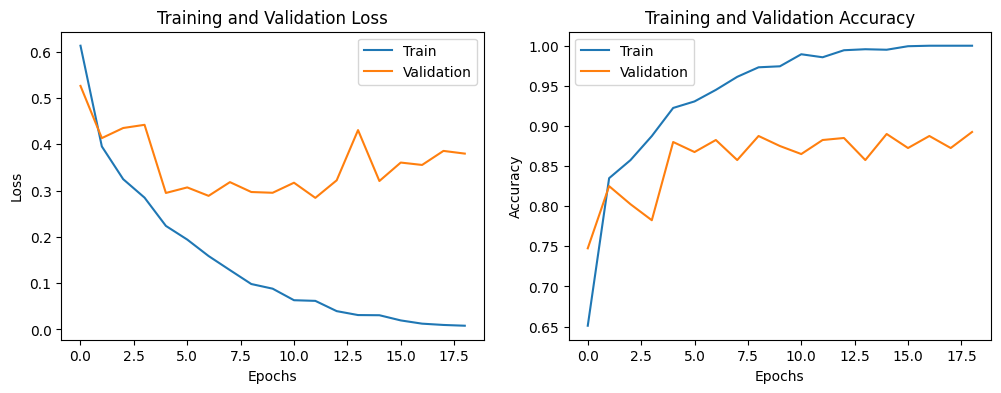

In [40]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step


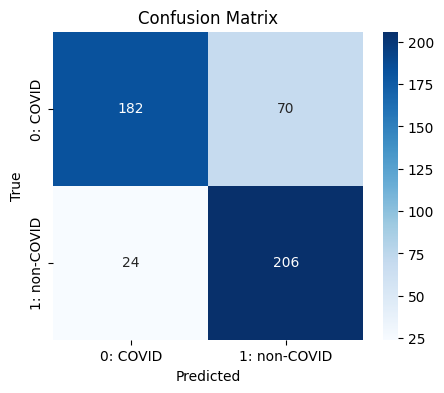

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       252
           1       0.75      0.90      0.81       230

    accuracy                           0.80       482
   macro avg       0.81      0.81      0.80       482
weighted avg       0.82      0.80      0.80       482



In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

y_pred = model.predict(X_test, batch_size=16)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# y_pred = model.predict(X_test, batch_size=16)
# y_true = y_test.reshape(-1, 1)
# y_pred_classes = np.round(y_pred).astype(int)
# y_true_classes = y_true

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0: COVID', '1: non-COVID'],
            yticklabels=['0: COVID', '1: non-COVID'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, zero_division=0.0))

In [44]:
score, acc, p, r = model.evaluate(X_test, y_test, batch_size=16)
print('Test Loss =', score)
print('Test Accuracy =', acc)

c:\Users\nikba\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.8388 - loss: 0.6607 - precision_2: 0.8446 - recall_2: 0.8388
Test Loss = 0.7647051215171814
Test Accuracy = 0.8049792647361755
